Logs
- [2023/05/13]    
  First version of this notebook

# Example 7.6 - Autoregressive model

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sc_stats
import tabulate

from sklearn.linear_model import LinearRegression

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`

In [4]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  elif isinstance(columns, list):
    df = pd.read_excel(filename, engine="odf", header=0,
                       usecols=columns)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                      usecols=key_arr)
    df = df.rename(columns=columns)
  return df

### Get multiple regression coefficients

In [7]:
def get_multiple_regress_coeff(df, n_vars=2, with_intercept=True):  

  regress_obj = LinearRegression(fit_intercept=with_intercept)

  if isinstance(df, pd.DataFrame):
    num_of_samples = len(df)
    X_arr = np.zeros((num_of_samples, n_vars))
    Y = df["Y"].to_numpy()

    for i in range(n_vars):
      key = f"X_{i+1}"
      X_arr[:, i] = df[key].to_numpy()

    regress = regress_obj.fit(X_arr, Y)
    df["hat_Y"] = regress.intercept_ + X_arr.dot(regress.coef_) 
  
  elif isinstance(df, np.ndarray):
    Y = df[:, 0]
    X_arr = df[:, 1:]

    
    regress = regress_obj.fit(X_arr, Y)
    Y_hat = regress.intercept_ + X_arr.dot(regress.coef_)
    df = np.column_stack([df, Y_hat])

  return regress, df


### Get Minitab output of Regression Analysis

In [84]:
def add_prediction_table(regress, df, significance_lvl=0.05):
  b0 = regress.intercept_
  b1 = regress.coef_[0]

  Y_tM1 = df["Y"].iloc[-1]        # Change this if the model is different

  n_data = len(df)
  hat_Y = b0 + b1*df_minitab["X_1"]

  meanX = df["X_1"].mean()
  sumOfSquareX_of_meanX = ((df["X_1"] - meanX)**2).sum()
  sumOfSquareY_of_hat_Y = ((df["Y"] - hat_Y)**2).sum()
  squareX = (Y_tM1 - meanX)**2

  std_yx = np.sqrt(sumOfSquareY_of_hat_Y/(n_data - 2))

  # -- for confidence interval (CI) and minitab S.E. of fit
  #    This measure the dispersion of the sample regression line
  #    about the population regression line
  std_err_fit = std_yx * np.sqrt(
    1./n_data + squareX/sumOfSquareX_of_meanX)

  std_forecast = std_yx * np.sqrt(
    1. + 1./n_data + squareX/sumOfSquareX_of_meanX)

  deg_of_freedom = n_data - 2
  l_bound = sc_stats.t.ppf(significance_lvl/2, deg_of_freedom)
  u_bound = sc_stats.t.ppf(1 - significance_lvl/2, deg_of_freedom)

  Y_t = b0 + b1*Y_tM1

  data = [
    [1, Y_t, std_err_fit, 
    f"({Y_t + l_bound * std_err_fit:.3f}, {Y_t + u_bound * std_err_fit:.3f})",
    f"({Y_t + l_bound * std_forecast:.3f}, {Y_t + u_bound * std_forecast:.3f})"]
  ]

  table_prediction = tabulate.tabulate(data, tablefmt='html', 
    headers=["New Obs", "Fit", "SE Fit", "95% CI", "95% PI"],
    floatfmt=[int, ".3f", ".3f", str, str])

  print(f"Predicted Values for New Observations")
  display(table_prediction)

In [85]:
def get_minitab_out(df, n_vars=2, new_column=None, withCorrMatrix=False, 
  withVIF=False, with_intercept=True, with_DW_stat=True, is_reg_diff=False,
  new_observ=0):

  """
  new_column (dict) : a dictionary mapping to rename df header
  is_reg_diff:
    True - if we perform regression difference of Y_t and X_t. 
    In this function, it only implements how to print the output not the
    calculation
  new_observ: int
    Number of forecasting point.
  """
  
  data_struct = np.zeros((len(df), 1+n_vars))
  data_struct[:, 0] = df['Y']
  for i in range(n_vars):
    key = f"X_{i+1}"
    data_struct[:, i+1] = df[key]

  # -- compute correlation matrix
  corr_matrix = np.corrcoef(data_struct, rowvar=False)
  corr_matrix = corr_matrix[1:, 0:-1]    # only show lower triangle part of correlation matrix

  # -- compute regression intercept and coefficients
  regress, _ = get_multiple_regress_coeff(df, n_vars=n_vars, with_intercept=with_intercept)
  b_arr = [regress.intercept_] + regress.coef_.tolist()
  is_positive_b_arr = [b_j > 0 for b_j in b_arr]
  #print(f"b_arr: {b_arr}")
  
  # -- compute standad error of the estimates
  num_of_samples = len(df)
  hat_Y =  regress.intercept_ + data_struct[:,1:].dot(regress.coef_)
  sumSq_Y_hat_Y = ((data_struct[:, 0] - hat_Y)**2).sum()

  if with_intercept:
    s_yxs = np.sqrt(sumSq_Y_hat_Y/(num_of_samples - n_vars - 1))
  else:
    s_yxs = np.sqrt(sumSq_Y_hat_Y/(num_of_samples - n_vars))

  # -- compute cofactor matrix 
  if with_intercept:
    X_arr = np.ones_like(data_struct)
    X_arr[:,1:] = data_struct[:,1:]
    cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix
  else:
    X_arr = data_struct[:, 1:]
    cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix
  

  # -- compute standard error of intercept_ and coef_
  # -- compute t-score of intecept_ and coef_
  # -- compute p-values of intercept_ and coef_
  SE_coef = np.zeros(1+n_vars)
  t_scores = np.zeros(1+n_vars)
  p_values = np.zeros(1+n_vars)
  
  if with_intercept:
    dof = num_of_samples - n_vars - 1;          # degrees of freedom
    for i in range(1+n_vars):
      SE_coef[i] = s_yxs*np.sqrt(cofactor_matrix[i, i])
      t_scores[i] = b_arr[i] / SE_coef[i]
      p_values[i] = sc_stats.t.sf(abs(t_scores[i]), dof) * 2   # .t.sf is a survival function (1 - cdf)
  else:
    dof = num_of_samples - n_vars;          # degrees of freedom
    for i in range(1, 1+n_vars):
      SE_coef[i] = s_yxs*np.sqrt(cofactor_matrix[i-1, i-1])
      t_scores[i] = b_arr[i] / SE_coef[i]
      p_values[i] = sc_stats.t.sf(abs(t_scores[i]), dof) * 2   # .t.sf is a survival function (1 - cdf)

  # -- compute VIF of coef_
  if withVIF:
    # if n_vars == 2, we calculate VIF from correlation matrix
    VIF_arr = np.zeros(n_vars)
    if n_vars == 2:
      VIF_arr[0] = 1/(1-corr_matrix[1, 1]**2)
      VIF_arr[1] = 1/(1-corr_matrix[1, 1]**2)
    else:
      for i in range(n_vars):
        # take a predictor column and put the other predictor after it
        predictor_data_struct = np.zeros((num_of_samples, n_vars))
        predictor_data_struct[:,0] = data_struct[:, i+1]   
        predictor_data_struct[:,1:] = np.delete(data_struct, i+1, axis=1)[:,1:]  
        #print(predictor_data_struct)
        predictor_SST, predictor_SSR, _ = get_sumSq(predictor_data_struct, n_vars=n_vars)
        predictor_R_sq = predictor_SSR/predictor_SST
        #print(predictor_R_sq)
        VIF_arr[i] = 1/(1 - predictor_R_sq)


  # -- compute ANOVA table
  meanY = data_struct[:, 0].mean()
  if with_intercept:
    SSR = ((hat_Y - meanY)**2).sum()
    SST = ((data_struct[:, 0] - meanY)**2).sum()
  else:
    SSR = (hat_Y**2).sum()
    SST = (data_struct[:, 0]**2).sum()

  SSE = ((data_struct[:, 0] - hat_Y)**2).sum()
  anova_sumSq = np.array([SSR, SSE, SST])

  if with_intercept:
    anova_dof = np.array([n_vars, num_of_samples - n_vars - 1, num_of_samples - 1], dtype=int)
  else:
    anova_dof = np.array([n_vars, num_of_samples - n_vars, num_of_samples], dtype=int)
  
  anova_meanSq = (anova_sumSq/anova_dof)[:2]
  anova_F_score = anova_meanSq[0] / anova_meanSq[1]
  anova_p_value = sc_stats.f.sf(anova_F_score, anova_dof[0], anova_dof[1])   # sf is a surfifal function (1 - cdf)

  # -- compute R_sq (coefficient of determination)
  R_sq = SSR/SST

  # -- compute adjusted R_sq
  adj_R_sq = 1 - (1 - R_sq)*(num_of_samples-1)/(num_of_samples-n_vars-1)
  
  # -- calculate Durbin-Watson statistics
  e_t = data_struct[:, 0] - hat_Y
  numerator = ((e_t[1:] - e_t[:-1])**2).sum()
  dw_stats = numerator / (e_t**2).sum()

  # -- create tabular form for correlation 
  if withCorrMatrix:
    data = []
    for i in range(n_vars):
      data_row = [new_column[i+1]] + \
        [f"{corr:.3f}" if j < i+1 else "" for j, corr in enumerate(corr_matrix[i,:])]
      #print(data_row)
      #print([type(data_row_i) for data_row_i in data_row])
      data.append(data_row)

    table_corr = tabulate.tabulate(data, tablefmt='html', 
      headers=[""] + new_column[:n_vars], 
      floatfmt=["None"] + [".3f"]*(n_vars))

    print(f"Correlations: {', '.join(new_column)}")
    display(table_corr)

  # -- create tabular form for predictor
  data = [["Constant", b_arr[0], SE_coef[0], t_scores[0], p_values[0]]]
  if withVIF:
    for i in range(1, n_vars+1):
      data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i], VIF_arr[i-1]]
      data.append(data_row)
    table_predictor = tabulate.tabulate(data, tablefmt='html', 
      headers=["Predictor", "Coef", "SE Coef", "t-score", "p-value", "VIF"], 
      floatfmt=[None, ".4f", ".4f", ".2f", ".4f", ".3f"])
  else:
    for i in range(1, n_vars+1):
      data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i]]
      data.append(data_row)
    table_predictor = tabulate.tabulate(data, tablefmt='html', 
      headers=["Predictor", "Coef", "SE Coef", "t-score", "p-value"], 
      floatfmt=[None, ".4f", ".4f", ".2f", ".4f"])


  print(f"Regression Analysis: {new_column[0]} versus {', '.join(new_column[1:])}")
  print("The regression equation is")
  str_b_predictor = "" 
  for i in range(n_vars):
    sign = "+" if is_positive_b_arr[i+1] else "-"
    str_b_predictor += f" {sign} {abs(b_arr[i+1]):.3f} {new_column[i+1]}"
  if with_intercept:
    print(f"{new_column[0]} = {b_arr[0]:.3f}{str_b_predictor}")
  else:
    if str_b_predictor[1] == "+":
      str_b_predictor = str_b_predictor[3:]
    print(f"{new_column[0]} = {str_b_predictor}")
  display(table_predictor)
  if is_reg_diff:
    print(f"s_yxs = {s_yxs:.4f}")
  else:
    print(f"s_yxs = {s_yxs:.4f}   R_sq = {R_sq*100:.1f}%   R-sq(adj) = {adj_R_sq*100:.1f}%")

  # -- create ANOVA table (with F-score and its p-value)
  data = [
    ["Regression",     anova_dof[0], anova_sumSq[0], f"{anova_meanSq[0]:.4f}", f"{anova_F_score:.3f}", f"{anova_p_value:.4f}"],
    ["Residual error", anova_dof[1], anova_sumSq[1], f"{anova_meanSq[1]:.4f}", "", ""],
    ["Total",          anova_dof[2], anova_sumSq[2], "", "", ""]] 
  table_anova = tabulate.tabulate(data, tablefmt='html', 
    headers=["Source", "d.o.f", "sumSq", "meanSq", "F-score", "p-value"], 
    floatfmt=[None, ".0f", ".4f", "s", "s", "s"])

  print(f"Analyis of Variance")
  display(table_anova)

  if new_observ > 0:
    add_prediction_table(regress, df)

  # -- print Durbin-Watson statistics
  if with_DW_stat:
    print(f"Durbin-Watson Statistics = {dw_stats:.2f}")

  return {"regress": regress, "param_stderr": SE_coef, 
    "param_t_stat": t_scores, "param_p_vals": p_values,
    "corr_matrix": corr_matrix, "R_sq": R_sq, "dw_stats": dw_stats}


## Load data

### Sales and income data

In [6]:
filename = "07-table-02-novak-sales.ods"

df = read_ods(filename)

df

,Year,Sales ($ millions) (Y),Income ($ millions),Unemployment Rate
0,1990,8.0,336.1,5.5
1,1991,8.2,349.4,5.5
2,1992,8.5,362.9,6.7
3,1993,9.2,383.9,5.5
4,1994,10.2,402.8,5.7
5,1995,11.4,437.0,5.2
6,1996,12.8,472.2,4.5
7,1997,13.6,510.4,3.8
8,1998,14.6,544.5,3.8
9,1999,16.4,588.1,3.6


## First-order autoregressive model

### Regression Analysis

One year data is lost, we didn't fix it (Novak sales for 1989 are not known)

In [18]:
df_minitab = df[["Sales ($ millions) (Y)"]]
from_column_names = df_minitab.columns.to_list()
print(f"header: {from_column_names + ['Y-lagged']}")
to_column_names = ["Y"] + [f"X_{i+1}" for i in range(len(from_column_names) - 1)]


df_minitab = df_minitab.rename(columns=
  {k: v for k, v in zip(from_column_names, to_column_names)})

df_minitab["X_1"] = df_minitab["Y"].shift(1)
df_minitab = df_minitab.dropna()
df_minitab

header: ['Sales ($ millions) (Y)', 'Y-lagged']


,Y,X_1
1,8.2,8.0
2,8.5,8.2
3,9.2,8.5
4,10.2,9.2
5,11.4,10.2
6,12.8,11.4
7,13.6,12.8
8,14.6,13.6
9,16.4,14.6
10,17.8,16.4


In [86]:
column_name = ["Sales (Y)", "Y-lag"]
out_dict = get_minitab_out(df_minitab, n_vars=len(column_name)-1, 
  new_column=column_name, withVIF=False, withCorrMatrix=False, 
  with_DW_stat=False, new_observ=1)

Regression Analysis: Sales (Y) versus Y-lag
The regression equation is
Sales (Y) = -0.109 + 1.094 Y-lag


Predictor,Coef,SE Coef,t-score,p-value
Constant,-0.1093,0.3367,-0.32,0.7502
Y-lag,1.0939,0.0206,53.01,0.0000


s_yxs = 0.4875   R_sq = 99.5%   R-sq(adj) = 99.5%
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,1,667.7278,667.7278,2810.158,0.0000
Residual error,14,3.3266,0.2376,,
Total,15,671.0544,,,


Predicted Values for New Observations


New Obs,Fit,SE Fit,95% CI,95% PI
1,31.722,0.311,"(31.055, 32.390)","(30.482, 32.963)"


### Regression Analysis (intercept neglected)

The intercept coefficient in the regression above is small and
not significantly ($t$-stat is small) different from zero.
Rerunning the regression without intercept term leaves the estimate
of the slope coefficient, and subsequent forecast, essentially unchanged.

In [94]:
column_name = ["Sales (Y)", "Y-lag"]
out_dict_omit_intercept = get_minitab_out(df_minitab, n_vars=len(column_name)-1, 
  new_column=column_name, withVIF=False, withCorrMatrix=False, 
  with_DW_stat=False, with_intercept=False, new_observ=0)

Regression Analysis: Sales (Y) versus Y-lag
The regression equation is
Sales (Y) = 1.088 Y-lag


Predictor,Coef,SE Coef,t-score,p-value
Constant,0.0000,0.0000,0.00,0.0000
Y-lag,1.0876,0.0072,150.19,0.0000


s_yxs = 0.4727   R_sq = 99.9%   R-sq(adj) = 99.9%
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,1,5040.2184,5040.2184,22557.221,0.0000
Residual error,15,3.3516,0.2234,,
Total,16,5043.5700,,,


### Fitted line plot

In [87]:
df_fit = df_minitab.copy()
out_dict

{'regress': LinearRegression(),
 'param_stderr': array([0.33673342, 0.02063491]),
 'param_t_stat': array([-0.32469755, 53.01092299]),
 'param_p_vals': array([7.50210904e-01, 1.54434632e-17]),
 'corr_matrix': array([[0.99751831]]),
 'R_sq': 0.995042770192543,
 'dw_stats': 1.4566731376611115}

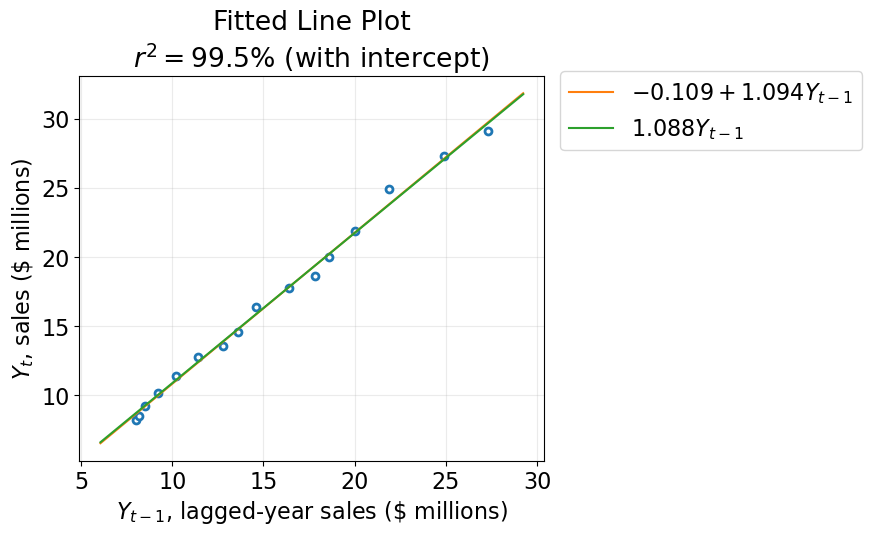

In [109]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(df_fit["X_1"], df_fit["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

regress = out_dict["regress"]
b0 = regress.intercept_
b1 = regress.coef_[0]

data_t_min = df_fit["X_1"].min()
data_t_max = df_fit["X_1"].max()
t_offset = 0.1*(data_t_max - data_t_min)
t_regress = np.linspace(data_t_min - t_offset, data_t_max + t_offset)
regress_label = r"${:.3f} + {:.3f}$".format(b0, b1) + r"$Y_{t-1}$" \
  if b1 > 0 else r"${:.3f}{:.3f}$".format(b0, b1) + r"$Y_{t-1}$"

ax.plot(t_regress, b0 + b1*t_regress, 
  linestyle='-',
  label=regress_label) 

regress_without_intercept = out_dict_omit_intercept["regress"]
b1 = regress_without_intercept.coef_[0]
regress_label = r"${:.3f}$".format(b1) + r"$Y_{t-1}$"
ax.plot(t_regress, b1*t_regress, linestyle="-", label=regress_label)

ax.set_xlabel(r"$Y_{t-1}$, lagged-year sales (\$ millions)")
ax.set_ylabel(r"$Y_t$, sales (\$ millions)")

rSq = out_dict["R_sq"]
ax.set_title("Fitted Line Plot\n" + r"$r^2={:.1f}$% (with intercept)".format(rSq*100))

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)

The fact that the estimated slope coefficient is about 1 suggests that
a forecast of next year's sales is very nearly this year's sales.